## Create dataset from directory

In [39]:
#%pip install pydot
#%pip install tensorflow --upgrade
#%pip install pip install scikit-image --upgrade
#%pip install keras --upgrade
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

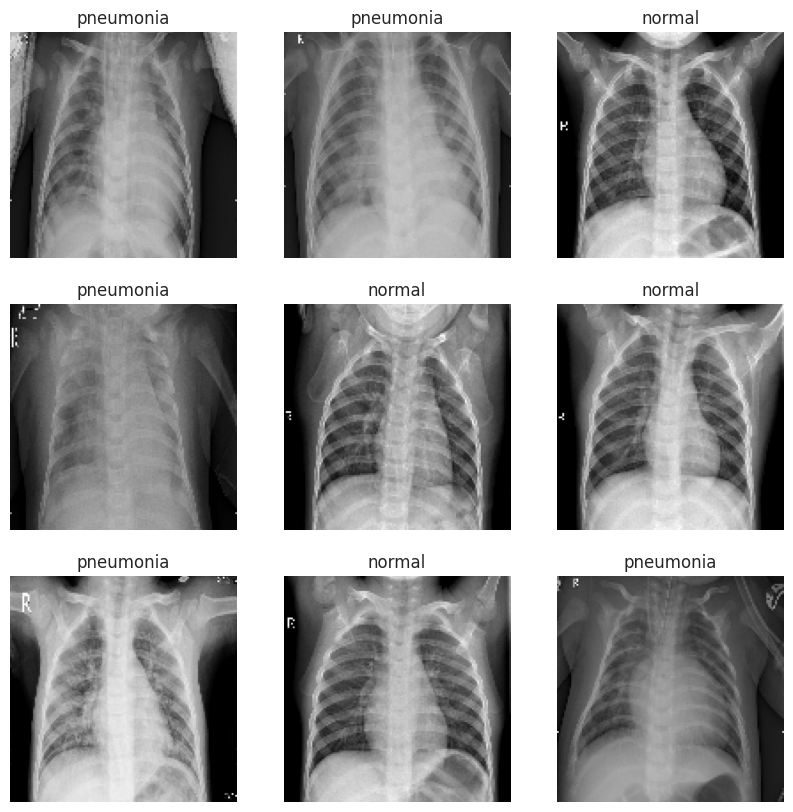

2024-05-11 18:26:29.123489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [11]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2024-05-11 18:26:36.935899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

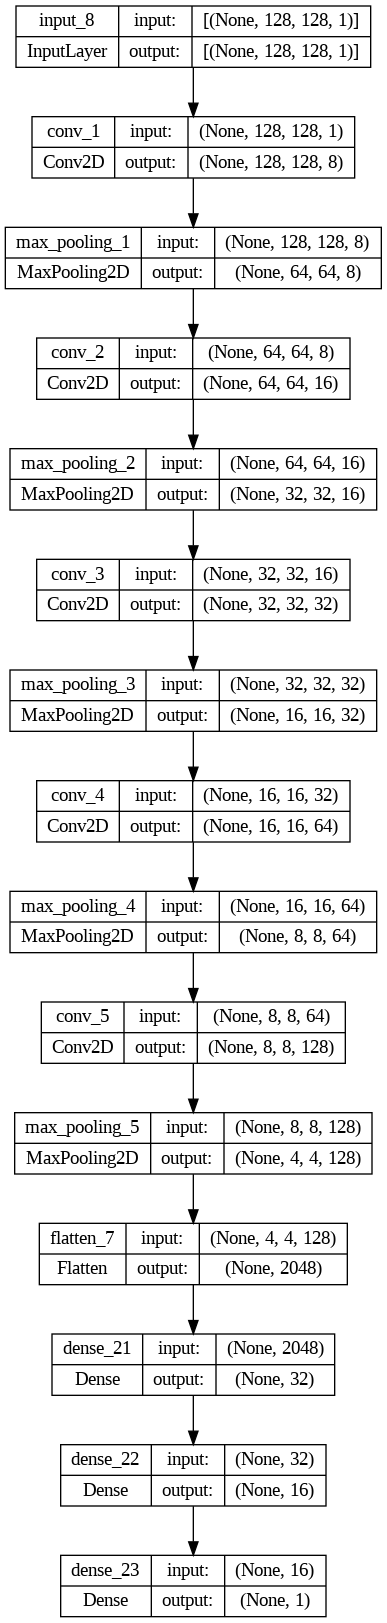

In [33]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.

conv_1 = layers.Conv2D(8, (3, 3), padding="same", activation='relu')(input)
maxpool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = layers.Conv2D(16, (3, 3), padding="same", activation='relu')(maxpool_1)
maxpool_2 = layers.MaxPooling2D((2, 2))(conv_2)
conv_3 = layers.Conv2D(32, (3, 3), padding="same", activation='relu')(maxpool_2)
maxpool_3 = layers.MaxPooling2D((2, 2))(conv_3)
conv_4 = layers.Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool_3)
maxpool_4 = layers.MaxPooling2D((2, 2))(conv_4)
conv_5 = layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_4)
maxpool_5 = layers.MaxPooling2D((2, 2))(conv_5)
flattened = layers.Flatten()(maxpool_5)
dense_1 = layers.Dense(32, activation='relu')(flattened)
dense_2 = layers.Dense(16, activation='relu')(dense_1)
output = layers.Dense(1, activation='sigmoid')(dense_2)

cnn = Model(inputs=input, outputs=output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

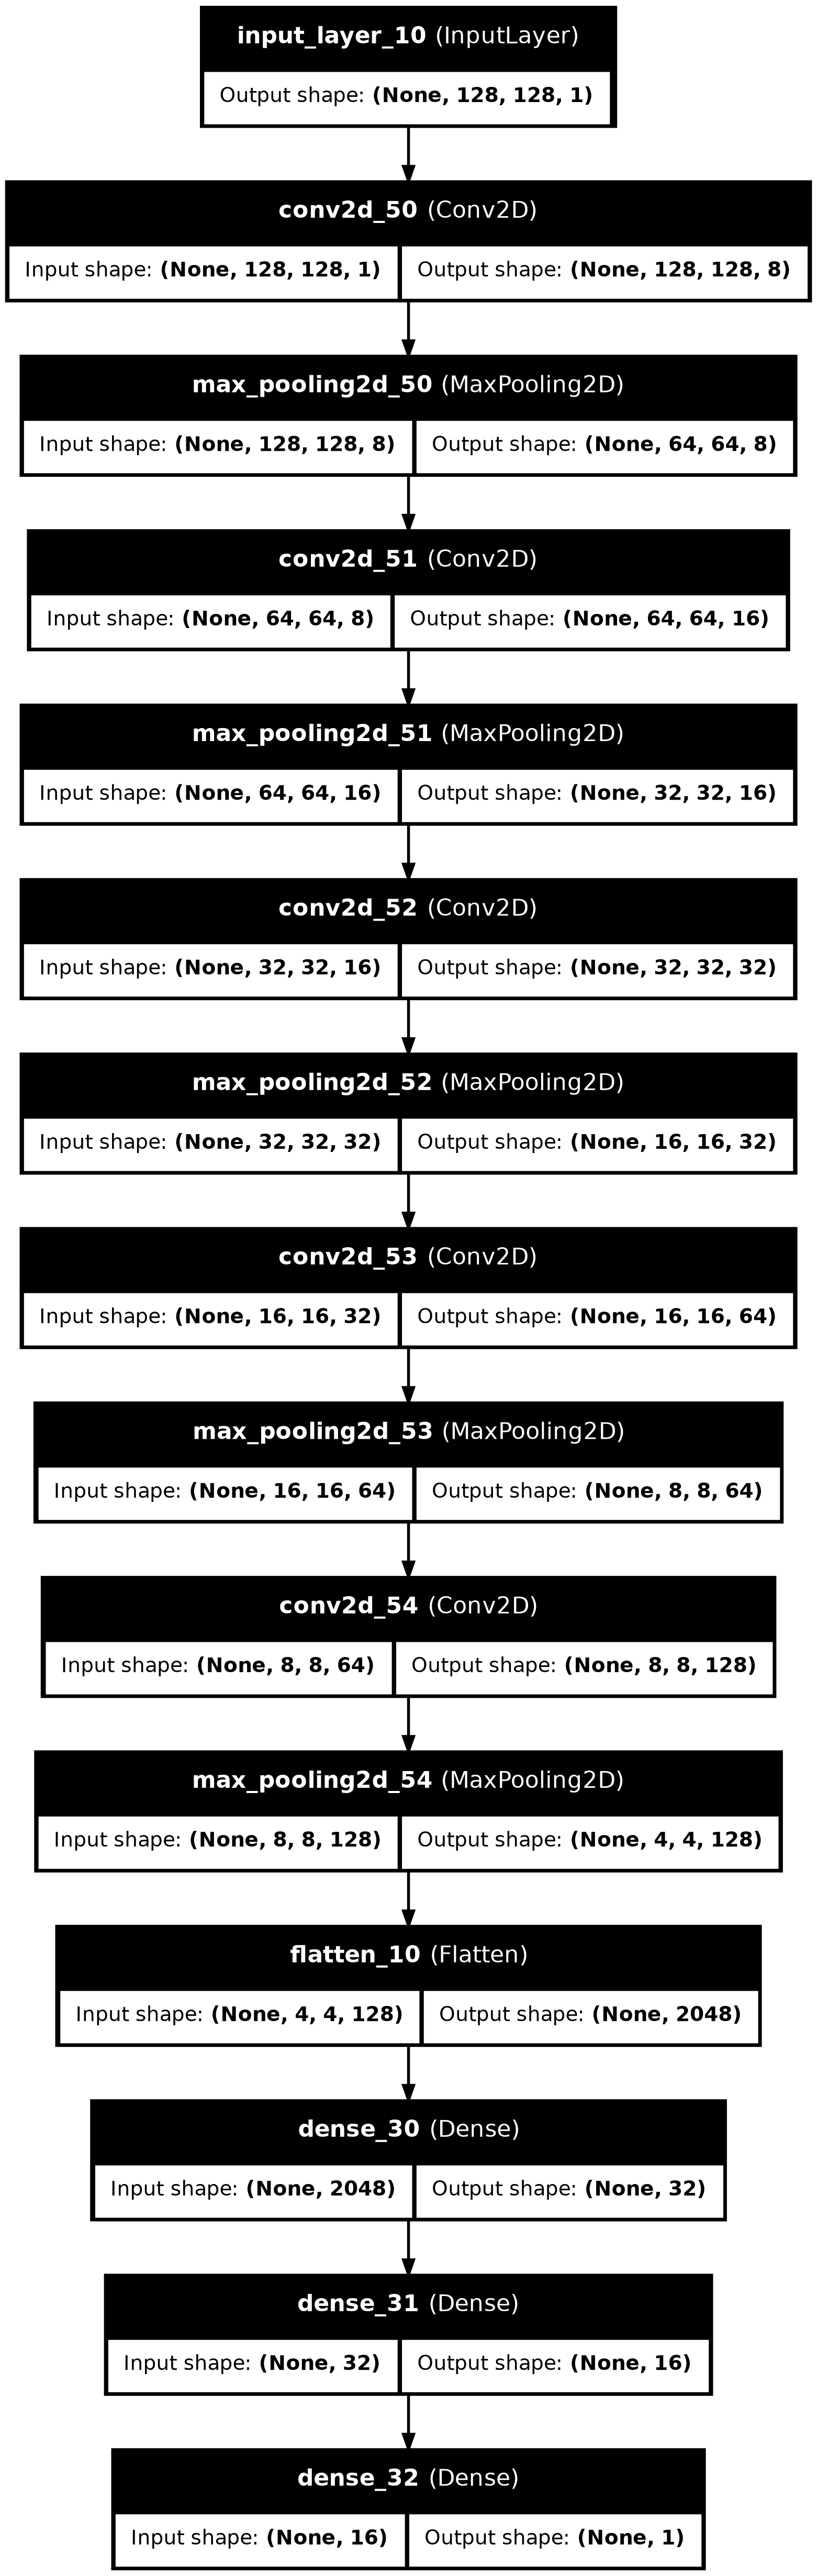

In [34]:
#from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [35]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    class_weight=class_weights
)

Epoch 1/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.7102 - loss: 1.6470 - val_accuracy: 0.6250 - val_loss: 0.5387
Epoch 2/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 333ms/step - accuracy: 0.9392 - loss: 0.1416 - val_accuracy: 0.8750 - val_loss: 0.2647
Epoch 3/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 35s 416ms/step - accuracy: 0.9583 - loss: 0.1062 - val_accuracy: 1.0000 - val_loss: 0.1007


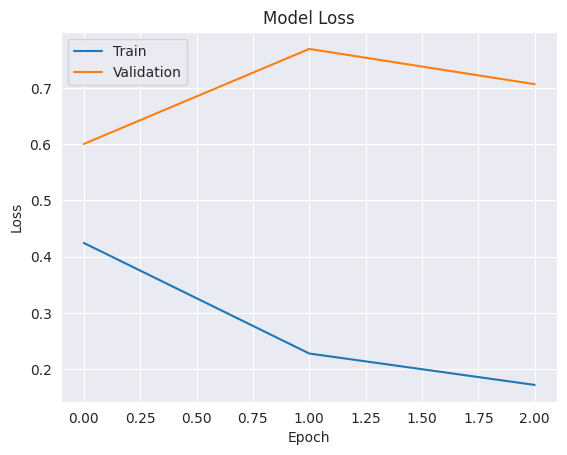

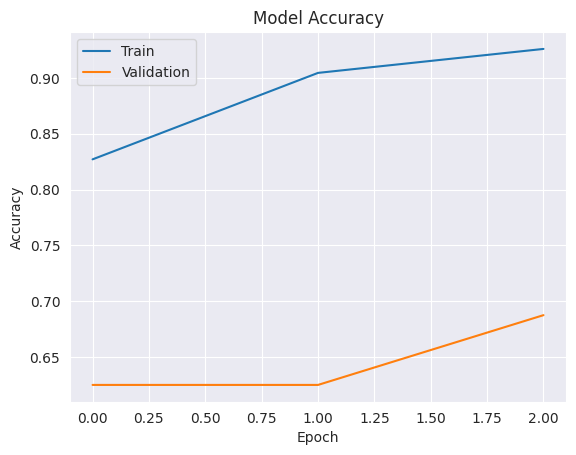

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)
from sklearn.metrics import confusion_matrix, f1_score

# Validation set
val_pred = cnn.predict(val_ds)
val_pred = np.round(val_pred).astype(int)

val_true_labels = []
for _, labels in val_ds:
    val_true_labels.extend(labels.numpy().astype(int))

val_conf_matrix = confusion_matrix(val_true_labels, val_pred)
val_f1 = f1_score(val_true_labels, val_pred)

print("Validation Confusion Matrix:")
print(val_conf_matrix)
print("Validation F1 Score:", val_f1)

# Test set
test_images = []
test_labels = []

for img, label in test_ds:
    test_images.append(img)
    test_labels.append(label)

test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

test_pred = cnn.predict(test_images)
test_pred = np.round(test_pred).astype(int)

test_conf_matrix = confusion_matrix(test_labels, test_pred)
test_f1 = f1_score(test_labels, test_pred)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)
print("Test F1 Score:", test_f1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


2024-05-11 18:51:51.109358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-11 18:51:51.252624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Confusion Matrix:
[[6 2]
 [2 6]]
Validation F1 Score: 0.75


2024-05-11 18:51:52.312539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step

Test Confusion Matrix:
[[121 113]
 [  6 384]]
Test F1 Score: 0.8658399098083427
